In [1]:
import os
import h5py
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataset import Subset
import torch.backends.cudnn as cudnn
from tqdm.auto import tqdm
import torchvision.models as models
import torchvision.transforms as transforms

# Ensure reproducibility (though not perfect due to CUDA)
torch.manual_seed(42)
np.random.seed(42)
cudnn.benchmark = True  # Can speed up training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# %% Cell 2: Custom Dataset class for HDF5 data
class DogH5Dataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        # We open the file in __init__ to load class_names (static info)
        # but images/labels can be lazily accessed if needed.
        self.h5_file = h5py.File(self.h5_file_path, 'r')
        self.images = self.h5_file['images']  # shape: (N, 224, 224, 3), float16
        self.labels = self.h5_file['labels']  # shape: (N,), int64
        self.class_names = self.h5_file['class_names'][:]
        
        # Convert class_names from object arrays if needed
        self.class_names = [cn.decode('utf-8') if isinstance(cn, bytes) else cn for cn in self.class_names]
        
        # Optional transform for data augmentation/preprocessing
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # images are float16, convert to float32 
        img = self.images[idx].astype(np.float32)  # shape (224,224,3)
        
        # If transform is provided, apply it
        if self.transform:
            img = self.transform(img)
        else:
            # Default conversion for PyTorch
            img = np.transpose(img, (2, 0, 1))  # (3,224,224)
            img = torch.from_numpy(img)
        
        label = self.labels[idx]  # int
        # Convert to tensor
        label_t = torch.tensor(label, dtype=torch.long)
        return img, label_t

    def close(self):
        self.h5_file.close()

# %% Cell 3: Define ResNet50 model with custom classifier
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=120):
        super(ResNet50Classifier, self).__init__()
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(weights=True)
        
        # Freeze base model parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# %% Cell 4: Load dataset and create dataloaders
file_path = r"C:\Users\20200337\Desktop\PROGRAMMATION\02_DOG_RACE_PREDICTION\dog_dataset_no_aug.h5"

# Define transforms for ResNet50 preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset with transform
dataset = DogH5Dataset(file_path, transform=transform)

# Let's do a train/val split
dataset_size = len(dataset)  # should be 17586
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64  # Reduced batch size due to ResNet50 being larger
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

num_classes = len(dataset.class_names)

# %% Cell 5: Define training/evaluation routines and early stopping

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
        total_samples += images.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double().item() / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels)
            total_samples += images.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double().item() / total_samples
    return epoch_loss, epoch_acc

def save_checkpoint(model, epoch, val_loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'val_loss': val_loss
    }, path)

# Early stopping parameters
patience = 2  # you can choose an appropriate patience

# %% Cell 6: Main training loop with early stopping and checkpointing

model = ResNet50Classifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Only optimize the new FC layers

best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 100

checkpoint_dir = "./checkpoints_resnet50"
os.makedirs(checkpoint_dir, exist_ok=True)


Using device: cuda


c:\Users\20200337\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

for epoch in range(1, max_epochs+1):
    print(f"Epoch {epoch}/{max_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Evaluate on validation only every 10 epochs to save time
    if epoch % 5 == 0:
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save checkpoint
            checkpoint_path = os.path.join(checkpoint_dir, f"resnet50_epoch_{epoch:04d}_valloss_{val_loss:.4f}.pth")
            save_checkpoint(model, epoch, val_loss, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} validation checks.")

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Using device: cuda
Epoch 1/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 3.5279, Train Acc: 0.3260
Epoch 2/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 1.5952, Train Acc: 0.6562
Epoch 3/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 1.0433, Train Acc: 0.7447
Epoch 4/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.8396, Train Acc: 0.7787
Epoch 5/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.7481, Train Acc: 0.7930
Val Loss: 0.6156, Val Acc: 0.8303
Checkpoint saved: ./checkpoints_resnet50\resnet50_epoch_0005_valloss_0.6156.pth
Epoch 6/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.6707, Train Acc: 0.8094
Epoch 7/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.6359, Train Acc: 0.8153
Epoch 8/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.5955, Train Acc: 0.8262
Epoch 9/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.5647, Train Acc: 0.8342
Epoch 10/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.5435, Train Acc: 0.8434
Val Loss: 0.5399, Val Acc: 0.8403
Checkpoint saved: ./checkpoints_resnet50\resnet50_epoch_0010_valloss_0.5399.pth
Epoch 11/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.5226, Train Acc: 0.8467
Epoch 12/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4987, Train Acc: 0.8541
Epoch 13/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4823, Train Acc: 0.8548
Epoch 14/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4658, Train Acc: 0.8612
Epoch 15/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4502, Train Acc: 0.8650
Val Loss: 0.5140, Val Acc: 0.8474
Checkpoint saved: ./checkpoints_resnet50\resnet50_epoch_0015_valloss_0.5140.pth
Epoch 16/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4423, Train Acc: 0.8671
Epoch 17/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4241, Train Acc: 0.8750
Epoch 18/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.4169, Train Acc: 0.8756
Epoch 19/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3981, Train Acc: 0.8817
Epoch 20/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3934, Train Acc: 0.8825
Val Loss: 0.5172, Val Acc: 0.8431
No improvement for 1 validation checks.
Epoch 21/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3886, Train Acc: 0.8814
Epoch 22/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3787, Train Acc: 0.8859
Epoch 23/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3631, Train Acc: 0.8901
Epoch 24/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3492, Train Acc: 0.8947
Epoch 25/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3474, Train Acc: 0.8907
Val Loss: 0.5121, Val Acc: 0.8448
Checkpoint saved: ./checkpoints_resnet50\resnet50_epoch_0025_valloss_0.5121.pth
Epoch 26/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3354, Train Acc: 0.8968
Epoch 27/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3251, Train Acc: 0.9004
Epoch 28/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3188, Train Acc: 0.9025
Epoch 29/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3154, Train Acc: 0.9024
Epoch 30/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3120, Train Acc: 0.9047
Val Loss: 0.5184, Val Acc: 0.8411
No improvement for 1 validation checks.
Epoch 31/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.3052, Train Acc: 0.9032
Epoch 32/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.2897, Train Acc: 0.9110
Epoch 33/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.2858, Train Acc: 0.9118
Epoch 34/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.2838, Train Acc: 0.9131
Epoch 35/100


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Train Loss: 0.2750, Train Acc: 0.9141
Val Loss: 0.5350, Val Acc: 0.8351
No improvement for 2 validation checks.
Early stopping triggered.


In [3]:
import os
import h5py
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataset import Subset
import torch.backends.cudnn as cudnn
from tqdm.auto import tqdm
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = ResNet50Classifier(num_classes=num_classes).to(device)

Using device: cuda


Loading best checkpoint: ./checkpoints_resnet50\resnet50_epoch_0025_valloss_0.5121.pth


C:\Users\20200337\AppData\Local\Temp\ipykernel_380\3563491636.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint, map_location=devi

Testing:   0%|          | 0/55 [00:00<?, ?it/s]

Classification Report:
                                precision    recall  f1-score   support

                  Afghan_hound       0.95      0.93      0.94        40
           African_hunting_dog       0.96      0.96      0.96        26
                      Airedale       0.84      0.81      0.82        26
American_Staffordshire_terrier       0.73      0.59      0.65        27
                   Appenzeller       0.75      0.68      0.71        31
            Australian_terrier       0.88      0.78      0.82        36
            Bedlington_terrier       0.94      0.94      0.94        18
          Bernese_mountain_dog       0.93      0.98      0.96        44
              Blenheim_spaniel       0.93      0.89      0.91        45
                 Border_collie       0.73      0.56      0.63        34
                Border_terrier       0.94      1.00      0.97        33
                   Boston_bull       0.97      1.00      0.98        29
          Bouvier_des_Flandres       0.6

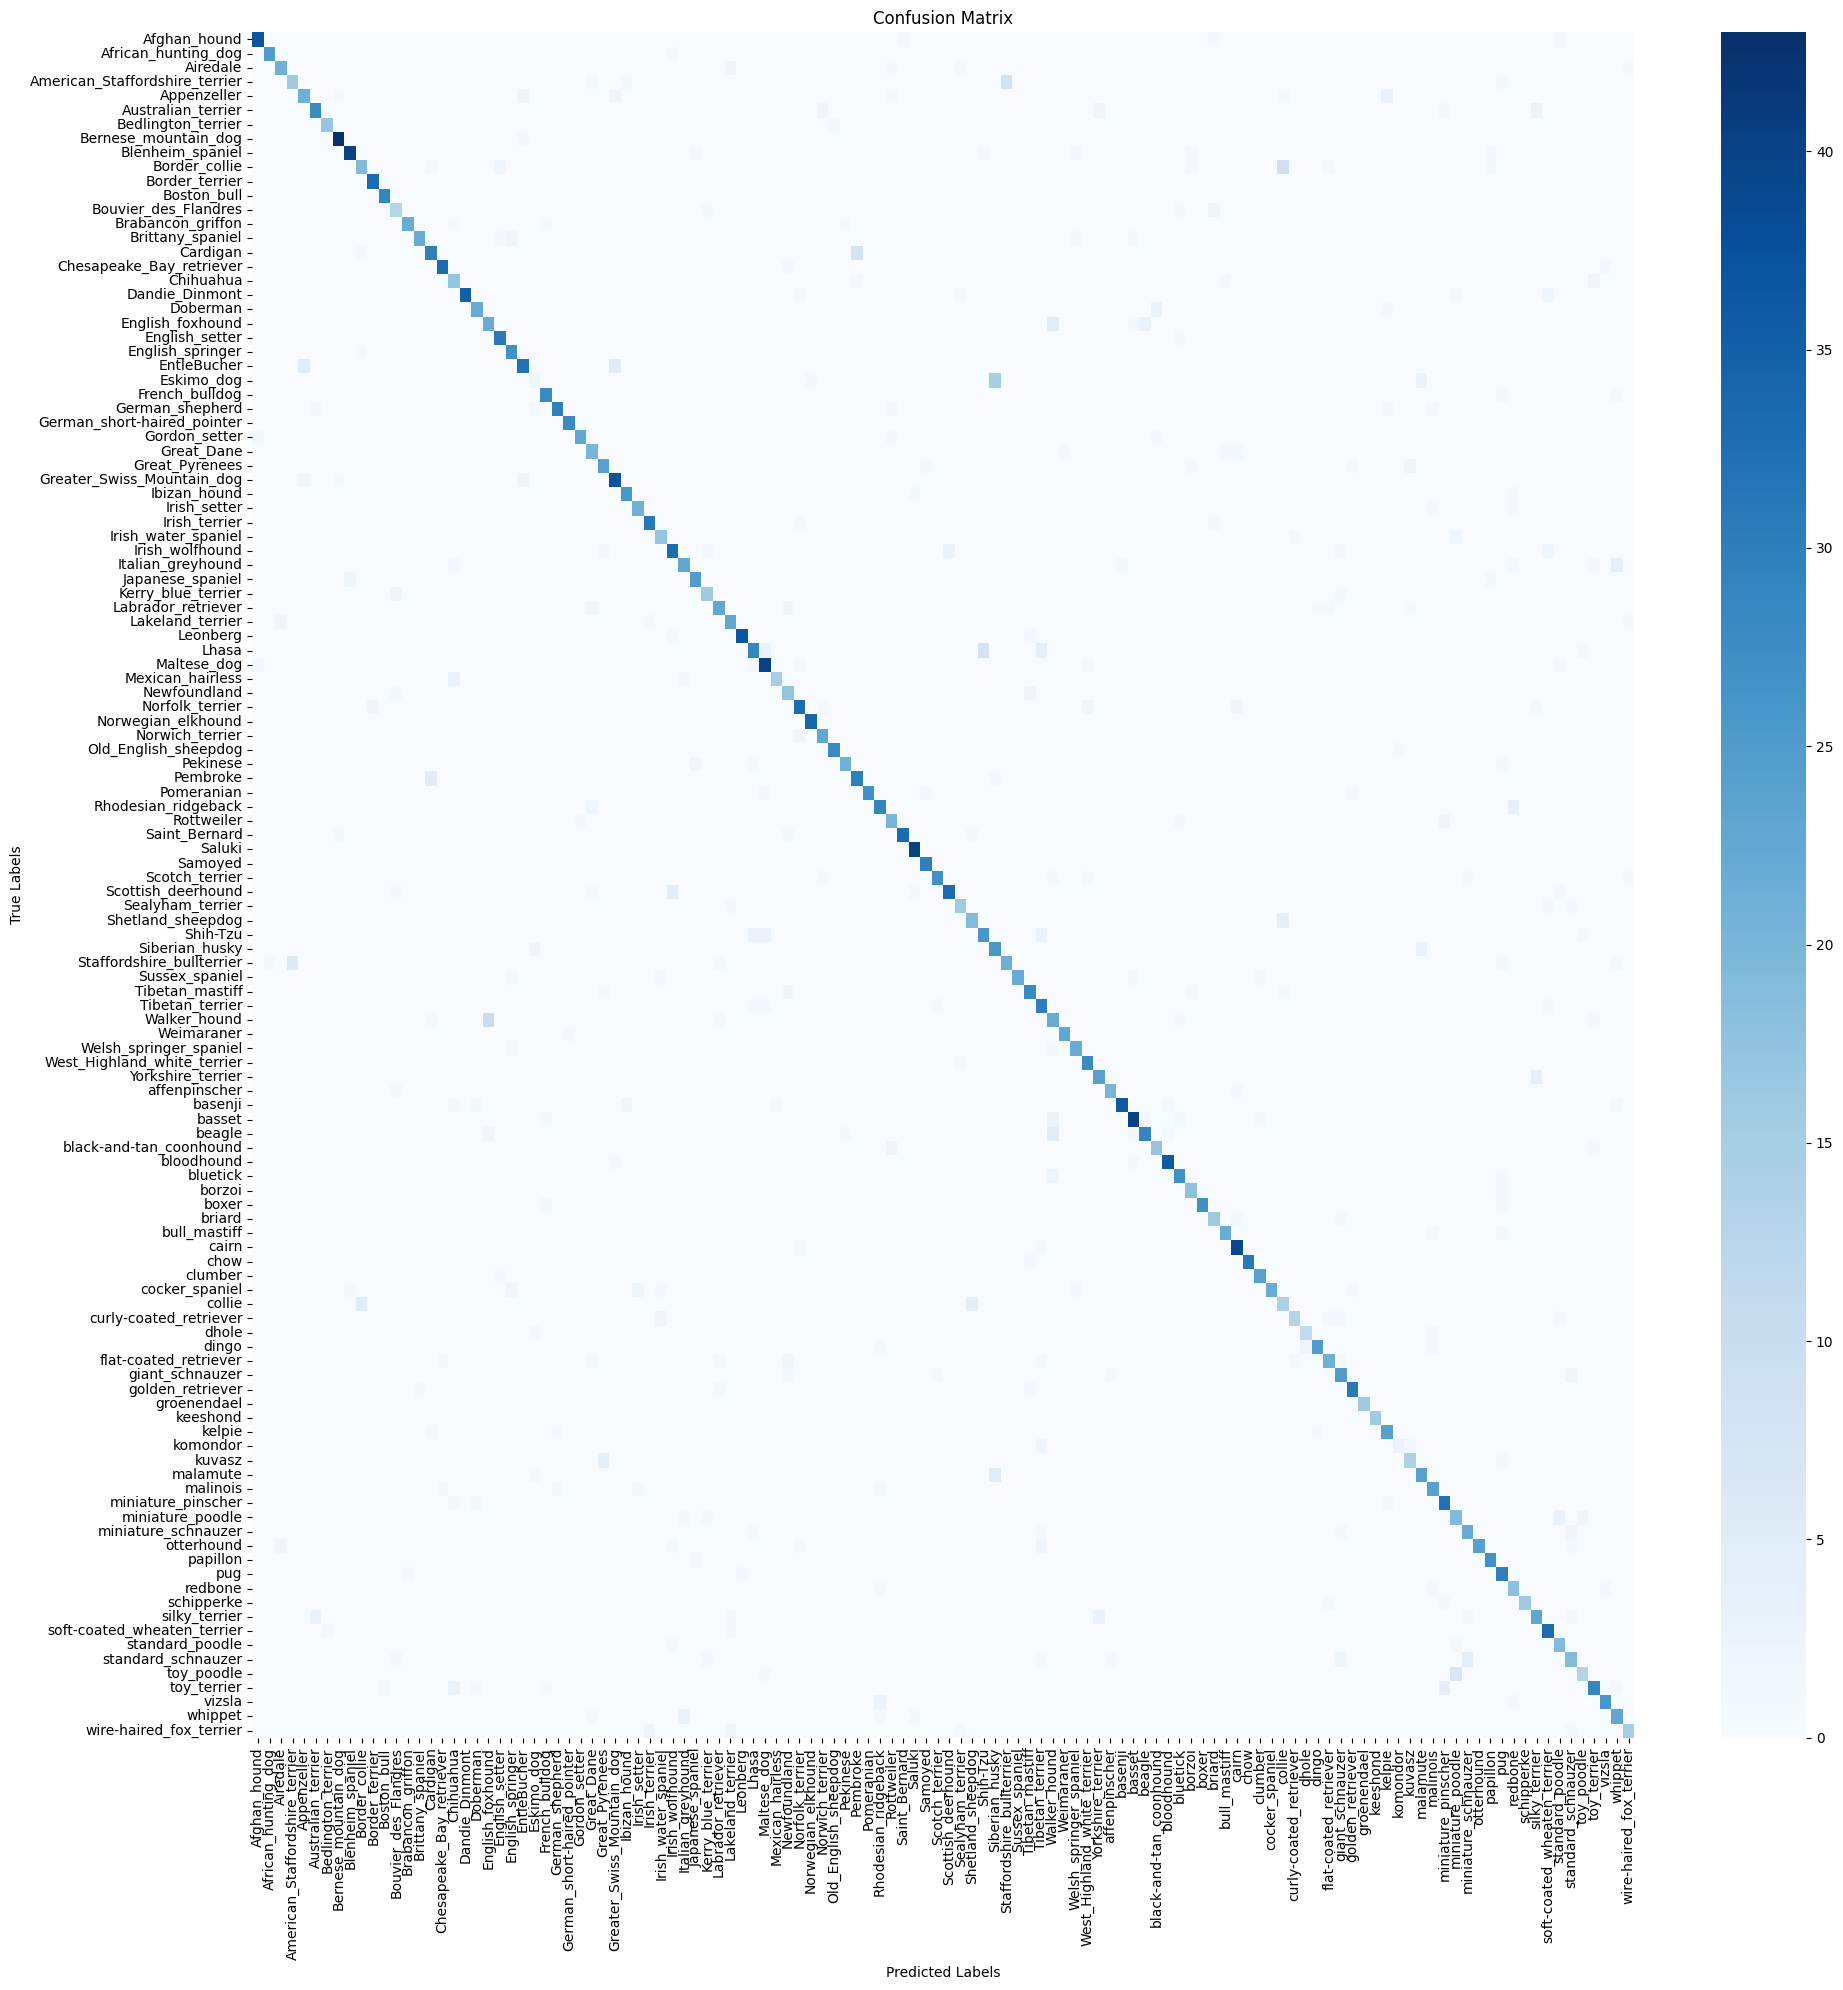

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to find the best checkpoint based on validation loss
def find_best_checkpoint(checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found in the directory.")
    
    # Extract val_loss from filenames
    def extract_val_loss(filename):
        try:
            val_loss_str = filename.split('valloss_')[1].replace('.pth', '')
            return float(val_loss_str)
        except:
            return float('inf')
    
    # Find the file with the smallest val_loss
    best_file = min(checkpoint_files, key=extract_val_loss)
    best_path = os.path.join(checkpoint_dir, best_file)
    return best_path

# Path to the checkpoint directory
checkpoint_dir = "./checkpoints_resnet50"

# Find and load the best checkpoint
best_checkpoint = find_best_checkpoint(checkpoint_dir)
print(f"Loading best checkpoint: {best_checkpoint}")

checkpoint = torch.load(best_checkpoint, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Function to get all predictions and true labels
def get_predictions(model, dataloader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Assuming val_loader is used as test_loader
test_loader = val_loader  # Replace with your actual test_loader if different

# Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader, device)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=dataset.class_names)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g',
            xticklabels=dataset.class_names,
            yticklabels=dataset.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
